In [79]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [80]:
BATCH_SIZE = 32
IMAGE_SIZE1 = 256
IMAGE_SIZE2 = 256
CHANNELS=3
EPOCHS=40

In [82]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Admin\\Downloads\\project things\\Diseases\\Training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 4 classes.


In [83]:
class_names = dataset.class_names
class_names

['Basal Cell Carcinoma', 'Eczema', 'Melanoma', 'Psoriasis']

In [84]:
len(dataset)

63

In [85]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 3 3 2 3 2 0 3 1 1 1 1 2 0 0 3 2 1 2 0 3 1 2 1 1 3 3 1 2 0 3]


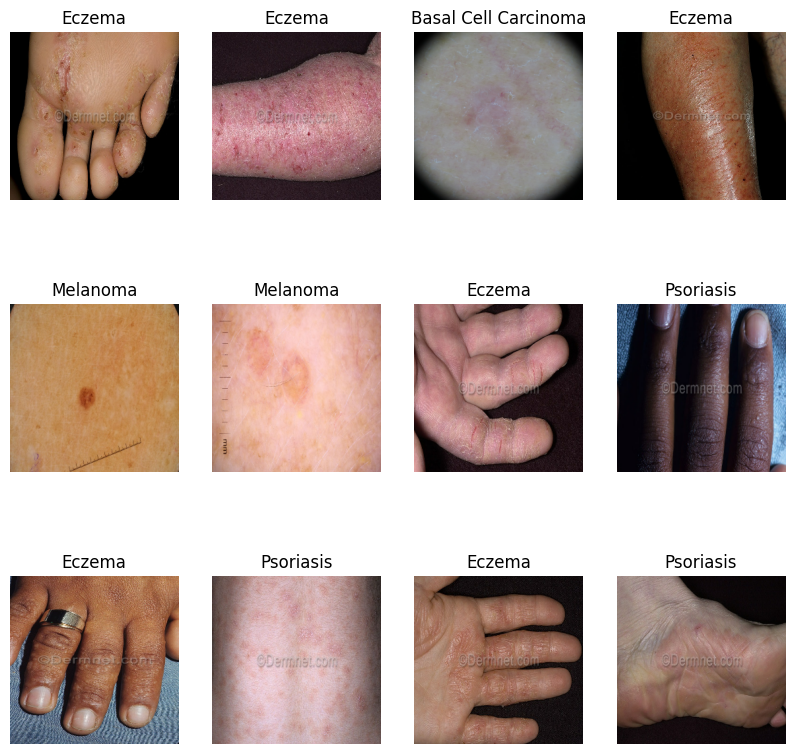

In [86]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [87]:
len(dataset)

63

In [88]:
train_size = 0.8
len(dataset)*train_size


50.400000000000006

In [89]:
train_ds = dataset.take(50)
len(train_ds)

50

In [90]:
test_ds = dataset.skip(50)
len(test_ds)

13

In [91]:
val_size=0.1
len(dataset)*val_size

6.300000000000001

In [92]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [93]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [94]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [95]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [96]:
len(train_ds)

50

In [97]:
len(val_ds)

6

In [98]:
len(test_ds)

7

In [99]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [100]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE1, IMAGE_SIZE2),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [101]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [102]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [103]:
input_shape = (BATCH_SIZE, IMAGE_SIZE1, IMAGE_SIZE2, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [104]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [105]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [106]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= 50,
)

Epoch 1/50
50/50 [==============================] - 103s 2s/step - loss: 1.2928 - accuracy: 0.3592 - val_loss: 1.0950 - val_accuracy: 0.4896
Epoch 2/50
50/50 [==============================] - 82s 2s/step - loss: 1.0310 - accuracy: 0.4672 - val_loss: 1.0187 - val_accuracy: 0.5052
Epoch 3/50
50/50 [==============================] - 85s 2s/step - loss: 0.9465 - accuracy: 0.5088 - val_loss: 0.9073 - val_accuracy: 0.5729
Epoch 4/50
50/50 [==============================] - 84s 2s/step - loss: 0.8773 - accuracy: 0.5758 - val_loss: 0.8233 - val_accuracy: 0.6719
Epoch 5/50
50/50 [==============================] - 83s 2s/step - loss: 0.8030 - accuracy: 0.6086 - val_loss: 0.8405 - val_accuracy: 0.6146
Epoch 6/50
50/50 [==============================] - 84s 2s/step - loss: 0.7641 - accuracy: 0.6193 - val_loss: 0.9002 - val_accuracy: 0.5781
Epoch 7/50
50/50 [==============================] - 85s 2s/step - loss: 0.7783 - accuracy: 0.6155 - val_loss: 0.8508 - val_accuracy: 0.5885
Epoch 8/50
50/50 [=

In [107]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 12s 672ms/step - loss: 0.4321 - accuracy: 0.8214


In [108]:
scores

[0.4320967495441437, 0.8214285969734192]

In [109]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [110]:
type(history.history['loss'])

list

In [111]:
len(history.history['loss'])

50

In [112]:
history.history['loss'][:5] 

[1.2927521467208862,
 1.03098726272583,
 0.9464551210403442,
 0.8772933483123779,
 0.8029516935348511]

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [114]:
model.save('C:\\Users\\Admin\\Documents\\Model\\model.h1')

INFO:tensorflow:Assets written to: C:\Users\Admin\Documents\Model\model.h1\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\Documents\Model\model.h1\assets


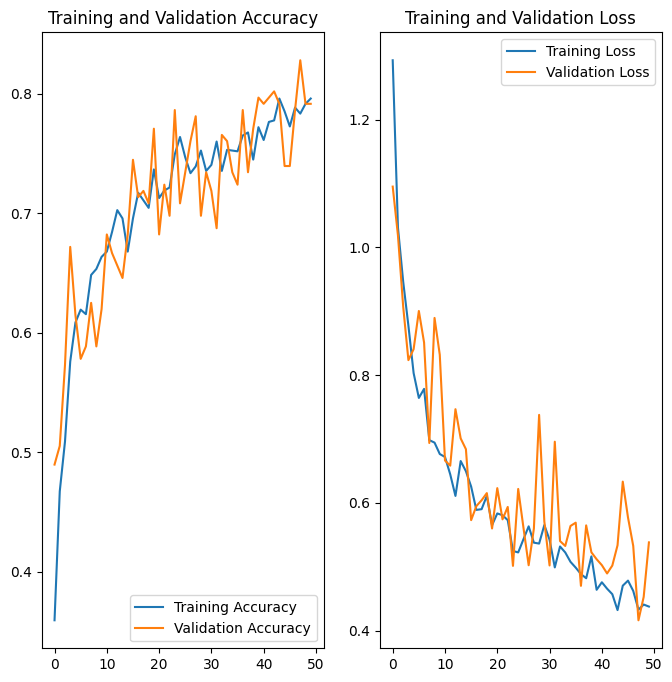

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Psoriasis
1/1 [==============================] - 1s 920ms/step
predicted label: Psoriasis


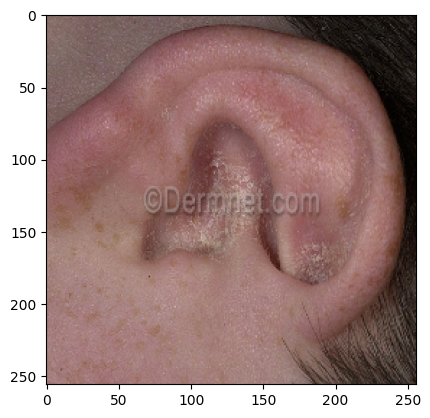

In [116]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [117]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    plt.imshow(img)
    return predicted_class, confidence

1/1 [==============================] - 0s 141ms/step


('Melanoma', 99.99)

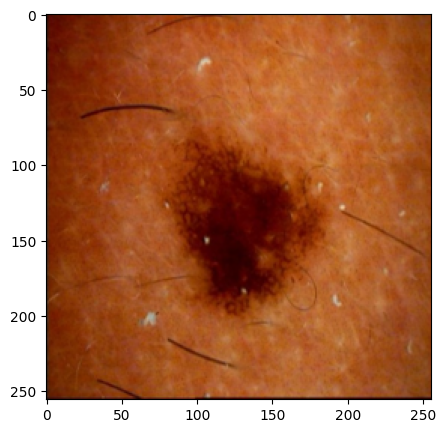

In [119]:
from PIL import Image
import numpy as np

image_path = 'C:\\Users\\Admin\\Downloads\\dataset\\2. Melanoma 15.75k\\ISIC_6670242.jpg'
image = Image.open(image_path)
img = image.resize((IMAGE_SIZE1, IMAGE_SIZE2))
plt.figure(figsize=(5, 5))

# Convert the image to a NumPy array
image_array = np.array(img)

new_model = tf.keras.models.load_model('C:\\Users\\Admin\\Documents\\Model\\model.h1')

predict(new_model, image_array)

1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 40ms/step


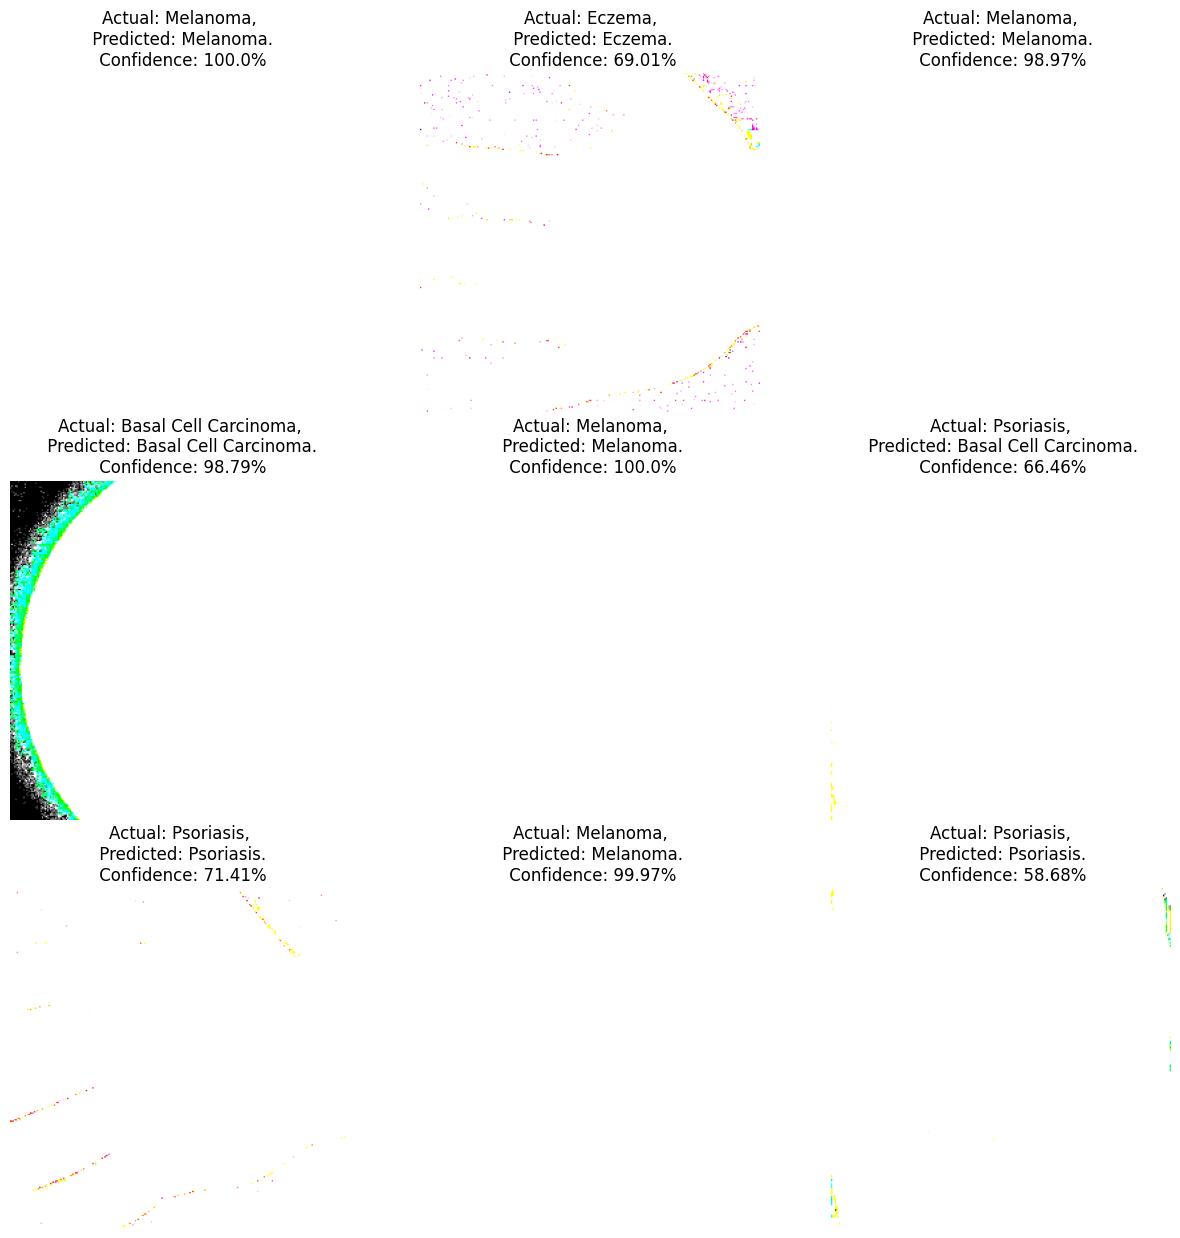

In [120]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [1]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'models'

In [47]:
model.save("../skin.h1")

INFO:tensorflow:Assets written to: ../skin.h1\assets


INFO:tensorflow:Assets written to: ../skin.h1\assets
